## 爬取(下載)資料

In [1]:
import requests
url = "https://storage.googleapis.com/kaggle-datasets/854/1575/nyse.zip"
data = {"GoogleAccessId": "web-data@kaggle-161607.iam.gserviceaccount.com",
"Expires": "1549443810",
'Signature': 'ihAvN5GNtZlnS6JoWy6FsbB+f3i9qDBD6IlBFkdp8lF9XmVE4KnwHKzmcwyYQtDUQt7Z7eouFZ1fnCvw/HuM0H9HoTDZlG9zRPz53UnwoKsruMIlDnVzwHUx1bpcJQY98IBluUdDpUEpNDZhg56nKoQ8MYs5rIMhKIA/xqCxOFymDmEB2DCGJTb3IjViBGSTbnuWJjs+g/X85ihhMFO9dOxGJ3+tAT6SsivYwG0wSjGZm3W1gySVg9+ECEdUFpuov74b9ZL0CeXZPcwrf93OYEd7Ep8hoGCj+8WhiXVVymfaVv2wDnLd78r3K9cYuP6DYtfjFAifGHOKcuOhvyGE5g=='}
res = requests.get(url,params = data)
with open("nyse.zip","wb") as nyse:
    nyse.write(res.content)

解壓縮

In [2]:
import zipfile
zip_ref = zipfile.ZipFile("nyse.zip",'r')
zip_ref.extractall("")
zip_ref.close()

PermissionError: [Errno 13] Permission denied: 'prices-split-adjusted.csv'

## 匯入資料

In [9]:
import pandas as pd
price = pd.read_csv("prices-split-adjusted.csv")
securities = pd.read_csv("securities.csv")

In [10]:
#預覽
print(price[:-5:-1])
print(securities[5::-1])

              date symbol       open      close        low       high  \
851263  2016-12-30    FTV  54.200001  53.630001  53.389999  54.480000   
851262  2016-12-30    AIV  44.730000  45.450001  44.410000  45.590000   
851261  2016-12-30    ZTS  53.639999  53.529999  53.270000  53.740002   
851260  2016-12-30   ZION  43.070000  43.040001  42.689999  43.310001   

           volume  
851263   705100.0  
851262  1380900.0  
851261  1701200.0  
851260  1938100.0  
  Ticker symbol             Security SEC filings             GICS Sector  \
5           AYI    Acuity Brands Inc     reports             Industrials   
4          ATVI  Activision Blizzard     reports  Information Technology   
3           ACN        Accenture plc     reports  Information Technology   
2          ABBV               AbbVie     reports             Health Care   
1           ABT  Abbott Laboratories     reports             Health Care   
0           MMM           3M Company     reports             Industrials   

 

## 資料預處理

In [11]:
price = price.set_index(price["date"],drop = True)
del price["date"]
price.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [12]:
price.index = pd.to_datetime(price.index, format = "%Y-%m-%d")
type(price.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [13]:
price = price.replace("WLTW",float('NaN'))
price = price[price["symbol"].isnull()]

In [14]:
price = price.fillna("WLTW")

## 空值處理

In [15]:
#為保留時間序列格式以及最小值 指派為9999-12-31
from datetime import datetime
securities = securities.fillna("9999-12-31")

In [16]:
securities["Date first added"]

0      9999-12-31
1      1964-03-31
2      2012-12-31
3      2011-07-06
4      2015-08-31
5      2016-05-03
6      1997-05-05
7      2015-07-09
8      9999-12-31
9      1976-06-30
10     2014-07-01
11     9999-12-31
12     9999-12-31
13     1985-04-30
14     2007-07-12
15     2016-05-13
16     2016-07-01
17     2012-05-25
18     2013-12-02
19     9999-12-31
20     2013-12-23
21     2016-07-01
22     9999-12-31
23     2014-04-03
24     9999-12-31
25     9999-12-31
26     2005-11-18
27     1991-09-19
28     2015-03-23
29     9999-12-31
          ...    
475    2009-12-21
476    9999-12-31
477    9999-12-31
478    1982-08-31
479    1979-12-31
480    9999-12-31
481    9999-12-31
482    2008-10-31
483    1976-06-30
484    2009-01-30
485    2009-07-01
486    9999-12-31
487    9999-12-31
488    9999-12-31
489    9999-12-31
490    9999-12-31
491    1975-03-31
492    2016-01-05
493    9999-12-31
494    2008-11-14
495    9999-12-31
496    9999-12-31
497    9999-12-31
498    9999-12-31
499    201

In [17]:
#依產業別分類之最早加入日期
from datetime import timedelta
import numpy as np
earlyest = pd.DataFrame(securities["Date first added"].groupby(securities["GICS Sector"]).min())
now =datetime.now()
day_to_now = pd.Series()
for i in earlyest["Date first added"]:
    day_to_now = day_to_now.append(pd.Series(now - datetime.strptime(i,"%Y-%m-%d")))
day_to_now.index = earlyest.index
day_to_now.name = "Days to now"
earlyest = earlyest.join(day_to_now)

In [18]:
for i in earlyest["Date first added"].index:
    earlyest.loc[i,"test"] = (now - datetime.strptime(earlyest.loc[i,"Date first added"],"%Y-%m-%d"))

In [19]:
earlyest.loc["Consumer Discretionary","test"] = 1
earlyest

,Date first added,Days to now,test
GICS Sector,,,
Consumer Discretionary,1970-06-30,17754 days 22:24:26.678185,1
Consumer Staples,1969-03-31,18210 days 22:24:26.678185,18210 days 22:24:26.678185
Energy,1965-03-31,19671 days 22:24:26.678185,19671 days 22:24:26.678185
Financials,1975-06-30,15928 days 22:24:26.678185,15928 days 22:24:26.678185
Health Care,1964-03-31,20036 days 22:24:26.678185,20036 days 22:24:26.678185
Industrials,1964-03-31,20036 days 22:24:26.678185,20036 days 22:24:26.678185
Information Technology,1974-12-31,16109 days 22:24:26.678185,16109 days 22:24:26.678185
Materials,1964-06-30,19945 days 22:24:26.678185,19945 days 22:24:26.678185
Real Estate,2007-01-10,4411 days 22:24:26.678185,4411 days 22:24:26.678185


## 視覺化分析

([<matplotlib.axis.XTick at 0x1ed3b18c940>,
 <a list of 11 Text xticklabel objects>)

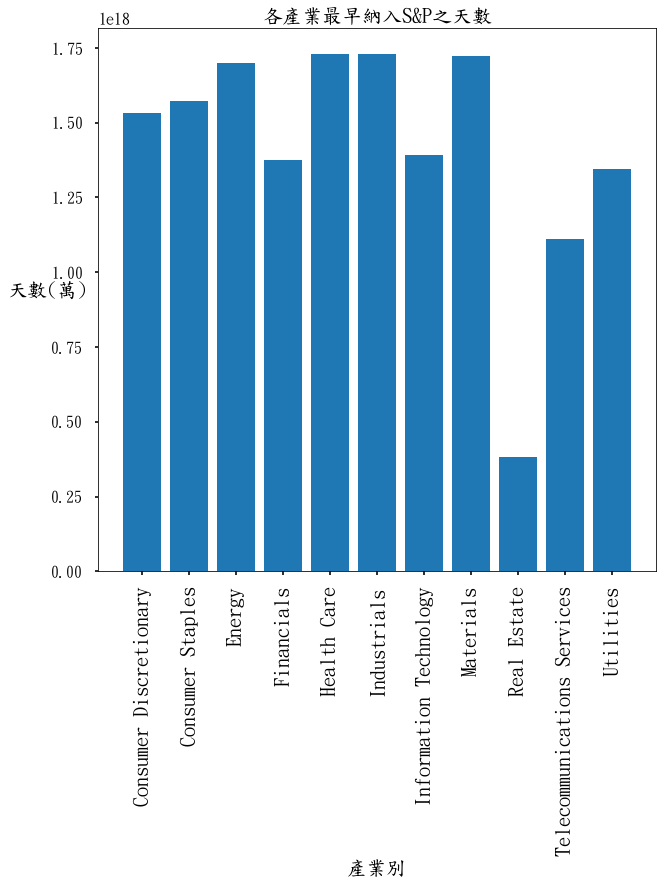

In [20]:
#繪圖
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-poster")
fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.rcParams['font.family']='DFKai-SB'
plt.bar(earlyest.index,earlyest["Days to now"],align='center')
plt.title("各產業最早納入S&P之天數",fontsize=20,fontweight='bold')
plt.xlabel('產業別',fontsize=20,fontweight='bold') #X軸名稱
plt.ylabel('天數(萬)',fontsize=20,fontweight='bold',rotation = "horizontal") #Y軸名稱
plt.xticks(earlyest.index, earlyest.index,fontsize=20,fontweight='bold', rotation=90)
#plt.savefig("各產業最早納入S&P之天數.png",format='png', dpi=300, pad_inches = 0)

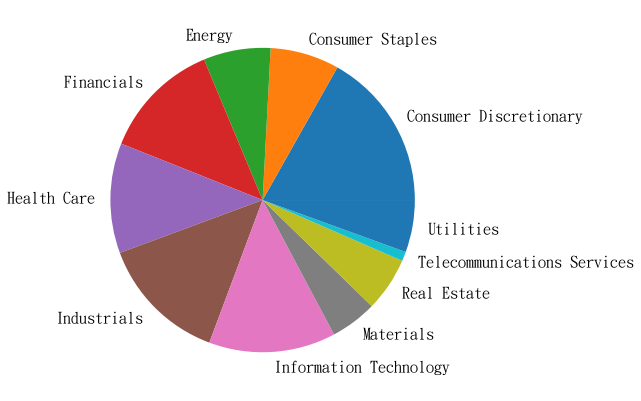

In [21]:
#各產業於S&P500之比例(數量)
amount =  pd.DataFrame(securities["Security"].groupby(securities["GICS Sector"]).count())
#繪圖
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-poster")
fig = plt.figure(figsize = (7,7))
plt.pie(amount,labels = amount.index)
plt.savefig("各產業於S&P之比例.png",format='png', dpi=300, pad_inches = 0)
# 第一次執行會有相鄰顏色相同的問題

## 創建變數
創建變數以進行機器學習

分析換倉日以及星期幾對於隔日開盤之影響

In [27]:
price["weekday"] = price.index.weekday+1
price

,symbol,open,close,low,high,volume,weekday
date,,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,3
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,4
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,5
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,1
2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0,2
2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0,3
2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0,4
2016-01-15,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0,5


In [28]:
#視覺化觀察 隔週開盤
price_close = price[["close",'weekday']]
price_close_1 = price[price['weekday'] ==1]

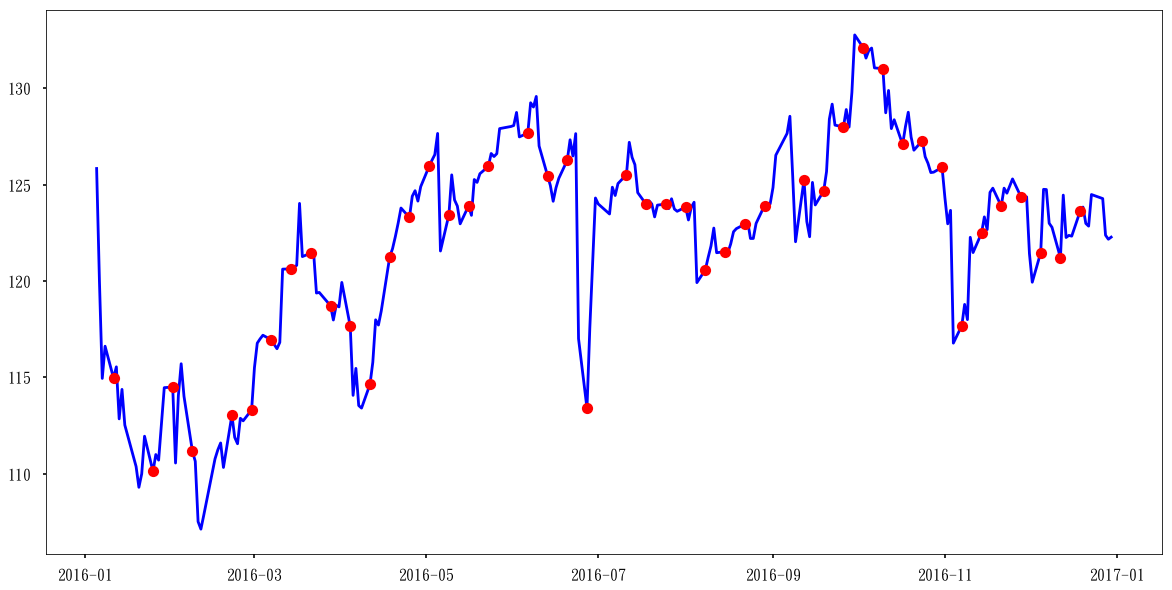

In [29]:
fig = plt.figure(figsize = (20,10))
plt.plot(price_close["close"],"b-")
plt.plot(price_close_1["close"],"ro")

In [30]:
#設定結算日
#分開計算加速
count = 0
price_close["settlement"] = 0
price_settle = price_close[["weekday","settlement"]]
for time in price_settle.index:
    if time.month == 3 or time.month == 6 or time.month == 9 or time.month == 12:
        if price_settle.loc[time]["weekday"] == 5:
            count +=1
        if count == 3:
            count = 0
            price_settle.loc[time]["settlement"] = 1
        else:
            price_settle.loc[time]["settlement"] = 0
    else:
        price_settle.loc[time]["settlement"] = 0
price_settle.loc[datetime(2016,9,9)]["settlement"] = 0
print(price_settle[price_settle["settlement"]==1])

            weekday  settlement
date                           
2016-03-18        5           1
2016-06-17        5           1
2016-09-30        5           1
2016-12-16        5           1


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [31]:
#合併結果
price = pd.merge(price,price_settle,left_on = 'date',right_on = 'date',how ='inner')

In [32]:
price.head()

,symbol,open,close,low,high,volume,weekday_x,weekday_y,settlement
date,,,,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2,2,0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,3,3,0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,4,4,0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,5,5,0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,1,1,0


In [33]:
del price["weekday_y"]

In [34]:
#加入幾號以分析月尾月首之影響
price["monthday"] = price.index.day
price.head()

,symbol,open,close,low,high,volume,weekday_x,settlement,monthday
date,,,,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2,0,5
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,3,0,6
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,4,0,7
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,5,0,8
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,1,0,11


In [39]:
price["mean_c"] = price['close'].rolling(window = 5,min_periods = 1).mean()
price["std_c"] = price["close"].rolling(window = 5,min_periods = 0).std()

In [42]:
price["std_c"] = price["std_c"].fillna(0)

In [43]:
price

,symbol,open,close,low,high,volume,weekday_x,settlement,monthday,mean_c,std_c
date,,,,,,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2,0,5,125.839996,0.000000
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,3,0,6,122.909999,4.143641
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,4,0,7,120.256665,5.450268
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,5,0,8,119.347500,4.807280
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,1,0,11,118.472000,4.600539
2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0,2,0,12,116.414001,2.105573
2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0,3,0,13,114.988000,1.374054
2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0,4,0,14,114.874000,1.401369
2016-01-15,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0,5,0,15,114.056000,1.318668


In [44]:
#創建答案列
import numpy as np
answer = np.zeros(price["close"].shape[0])
record = 0
count = 0
for time in price.index:
    if count > 0:
        if price.loc[time]['close'] > record:
            answer[count] = 1 #higher
        else:
            answer[count] = 0 #lower
    record = price.loc[time]['close']
    count+=1
answer

array([0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
       0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1.,
       1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0.,
       1., 1., 0., 1., 0.

In [46]:
df_ans = pd.get_dummies(answer)
df_ans.columns = ["lower","higher"]
df_ans.index = price.index
df_ans.head()

,lower,higher
date,,
2016-01-05,1,0
2016-01-06,1,0
2016-01-07,1,0
2016-01-08,0,1
2016-01-11,1,0


In [47]:
#合併
price = price.join(df_ans)

In [48]:
price

,symbol,open,close,low,high,volume,weekday_x,settlement,monthday,mean_c,std_c,lower,higher
date,,,,,,,,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2,0,5,125.839996,0.000000,1,0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,3,0,6,122.909999,4.143641,1,0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,4,0,7,120.256665,5.450268,1,0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,5,0,8,119.347500,4.807280,0,1
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,1,0,11,118.472000,4.600539,1,0
2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0,2,0,12,116.414001,2.105573,0,1
2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0,3,0,13,114.988000,1.374054,1,0
2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0,4,0,14,114.874000,1.401369,0,1
2016-01-15,WLTW,113.330002,112.529999,111.919998,114.879997,1093700.0,5,0,15,114.056000,1.318668,1,0


In [49]:
price.corr()

,open,close,low,high,volume,weekday_x,settlement,monthday,mean_c,std_c,lower,higher
open,1.000000,0.965911,0.981747,0.986666,-0.217654,0.007004,0.074603,0.010592,0.963543,-0.327003,0.036386,-0.036386
close,0.965911,1.000000,0.982822,0.981295,-0.255484,-0.007624,0.080852,0.035542,0.944771,-0.335899,-0.118062,0.118062
low,0.981747,0.982822,1.000000,0.981111,-0.288897,-0.021720,0.066650,0.044120,0.954249,-0.364559,-0.033898,0.033898
high,0.986666,0.981295,0.981111,1.000000,-0.183787,0.005322,0.091669,0.008608,0.964716,-0.295915,-0.014545,0.014545
volume,-0.217654,-0.255484,-0.288897,-0.183787,1.000000,0.141852,0.125177,-0.290394,-0.166095,0.481698,0.091945,-0.091945
weekday_x,0.007004,-0.007624,-0.021720,0.005322,0.141852,1.000000,0.178804,-0.013450,-0.014809,-0.005344,0.081121,-0.081121
settlement,0.074603,0.080852,0.066650,0.091669,0.125177,0.178804,1.000000,0.065918,0.064121,-0.013290,0.013769,-0.013769
monthday,0.010592,0.035542,0.044120,0.008608,-0.290394,-0.013450,0.065918,1.000000,0.008362,-0.193847,-0.046518,0.046518
mean_c,0.963543,0.944771,0.954249,0.964716,-0.166095,-0.014809,0.064121,0.008362,1.000000,-0.237632,0.045758,-0.045758
std_c,-0.327003,-0.335899,-0.364559,-0.295915,0.481698,-0.005344,-0.013290,-0.193847,-0.237632,1.000000,0.059792,-0.059792


In [55]:
price.dtypes

symbol         object
open          float64
close         float64
low           float64
high          float64
volume        float64
weekday_x       int64
settlement      int64
monthday        int64
mean_c        float64
std_c         float64
lower           uint8
higher          uint8
dtype: object

In [63]:
#漲跌差距
price["diff"] = price["close"].diff(1)

In [66]:
price.loc[datetime(2016,1,5),"diff"] = 0

In [67]:
price.head()

,symbol,open,close,low,high,volume,weekday_x,settlement,monthday,mean_c,std_c,lower,higher,diff
date,,,,,,,,,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,2,0,5,125.839996,0.000000,1,0,0.000000
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,3,0,6,122.909999,4.143641,1,0,-5.859993
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,4,0,7,120.256665,5.450268,1,0,-5.030006
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,5,0,8,119.347500,4.807280,0,1,1.670006
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,1,0,11,118.472000,4.600539,1,0,-1.650002


In [1]:
from sklearn.model_selection import train_test_split